In [28]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('../data/track_audio_dataset_no_lyrics.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77629 entries, 0 to 77628
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        77629 non-null  object 
 1   artist_name       77629 non-null  object 
 2   album_name        77629 non-null  object 
 3   genre             77629 non-null  object 
 4   duration_ms       77629 non-null  int64  
 5   popularity        77629 non-null  int64  
 6   explicit          77629 non-null  bool   
 7   track_id          77629 non-null  object 
 8   artist_id         77629 non-null  object 
 9   danceability      77629 non-null  float64
 10  energy            77629 non-null  float64
 11  key               77629 non-null  int64  
 12  loudness          77629 non-null  float64
 13  mode              77629 non-null  int64  
 14  speechiness       77629 non-null  float64
 15  acousticness      77629 non-null  float64
 16  instrumentalness  77629 non-null  float6

# Data Cleaning

In [4]:
# Replace booleans with integers
df.explicit = df.explicit.astype(int)

# Convert from milliseconds to seconds
df['duration_s'] = np.round(df.duration_ms/1000,0)

In [5]:
df.head()

,track_name,artist_name,album_name,genre,duration_ms,popularity,explicit,track_id,artist_id,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s
0,Hold On,Chord Overstreet,Hold On,acoustic,198853,83,0,5vjLSffimiIP26QG5WcN2K,5D3muNJhYYunbRkh3FKgX0,0.618,...,2,-9.681,1,0.0526,0.4690,0.0,0.0829,0.167,119.949,199.0
1,I'm Yours,Jason Mraz,We Sing. We Dance. We Steal Things.,acoustic,242186,83,0,1EzrEOXmMH3G43AXT1y7pA,4phGZZrJZRo4ElhRtViYdl,0.686,...,11,-8.322,1,0.0468,0.5950,0.0,0.1050,0.718,150.953,242.0
2,I Won't Give Up,Jason Mraz,Love Is a Four Letter Word (Deluxe Edition),acoustic,240165,73,0,53QF56cjZA9RTuuMZDrSA6,4phGZZrJZRo4ElhRtViYdl,0.585,...,4,-10.058,1,0.0398,0.6940,0.0,0.1150,0.142,136.703,240.0
3,Come On Get Higher,Matt Nathanson,Some Mad Hope,acoustic,215173,72,0,38YgZVHPWOWsKrsCXz6JyP,4NGiEU3Pkd8ASRyQR30jcA,0.672,...,9,-5.699,1,0.0297,0.2410,0.0,0.0848,0.617,92.018,215.0
4,Love Song,Sara Bareilles,Little Voice,acoustic,258826,75,0,4E6cwWJWZw2zWf7VFbH7wf,2Sqr0DXoaYABbjBo9HaMkM,0.583,...,2,-3.142,0,0.0301,0.0208,0.0,0.1880,0.573,123.055,259.0


# Exploratory Data Analysis 

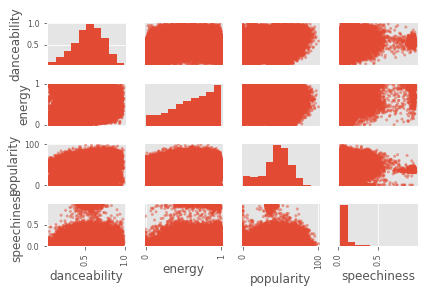

In [6]:
pd.plotting.scatter_matrix(df[['danceability','energy','popularity','speechiness']])
plt.tight_layout();

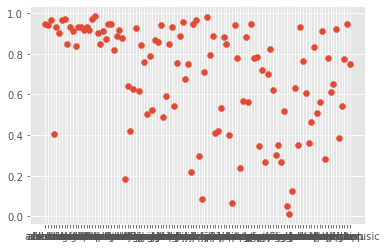

In [7]:
# Look for class imbalance across genres
genre_TracksPer1000 = df.groupby('genre').count().track_name / 1000

fig, ax = plt.subplots()

ax.scatter(genre_TracksPer1000.index, genre_TracksPer1000.values)

In [8]:
genre_TracksPer1000.sort_values()

genre
reggaeton    0.012
reggae       0.050
latino       0.066
indie-pop    0.085
rock         0.126
             ...  
indian       0.968
club         0.971
bluegrass    0.971
iranian      0.979
comedy       0.985
Name: track_name, Length: 112, dtype: float64

In [9]:
genre_TracksPer1000['pop']

0.266

In [10]:
genre_TracksPer1000[genre_TracksPer1000 > .8]

genre
acoustic          0.949
afrobeat          0.940
alt-rock          0.967
ambient           0.932
anime             0.901
black-metal       0.967
bluegrass         0.971
blues             0.846
brazil            0.934
breakbeat         0.911
british           0.837
cantopop          0.930
chicago-house     0.930
children          0.915
chill             0.930
classical         0.918
club              0.971
comedy            0.985
country           0.903
dance             0.848
dancehall         0.910
death-metal       0.875
deep-house        0.946
detroit-techno    0.949
disco             0.820
disney            0.889
drum-and-bass     0.918
dub               0.879
emo               0.925
forro             0.842
gospel            0.867
goth              0.858
grindcore         0.940
guitar            0.850
happy             0.930
hardstyle         0.889
heavy-metal       0.955
idm               0.949
indian            0.968
iranian           0.979
j-idol            0.889
k-pop     

<BarContainer object of 5 artists>

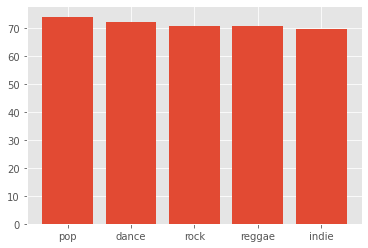

In [11]:
popularity_avg_by_genre = df.groupby('genre').mean().popularity
sorted_popularity_genre = popularity_avg_by_genre.sort_values(axis=0,ascending=False)

fig, ax = plt.subplots()
ax.bar(sorted_popularity_genre.index[:5],sorted_popularity_genre.values[:5])

In [12]:
# Creating a dataframe of only popular genres with a large number of data points (>800) to mitigate class imbalance
selected_genres=['acoustic','alt-rock','blues','classical',
                 'country','dance','deep-house','disco',
                 'hardstyle','heavy-metal','k-pop','tango']
ml_df = df[df['genre'].isin(selected_genres)].copy()

In [13]:
ml_df.head()

,track_name,artist_name,album_name,genre,duration_ms,popularity,explicit,track_id,artist_id,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s
0,Hold On,Chord Overstreet,Hold On,acoustic,198853,83,0,5vjLSffimiIP26QG5WcN2K,5D3muNJhYYunbRkh3FKgX0,0.618,...,2,-9.681,1,0.0526,0.4690,0.0,0.0829,0.167,119.949,199.0
1,I'm Yours,Jason Mraz,We Sing. We Dance. We Steal Things.,acoustic,242186,83,0,1EzrEOXmMH3G43AXT1y7pA,4phGZZrJZRo4ElhRtViYdl,0.686,...,11,-8.322,1,0.0468,0.5950,0.0,0.1050,0.718,150.953,242.0
2,I Won't Give Up,Jason Mraz,Love Is a Four Letter Word (Deluxe Edition),acoustic,240165,73,0,53QF56cjZA9RTuuMZDrSA6,4phGZZrJZRo4ElhRtViYdl,0.585,...,4,-10.058,1,0.0398,0.6940,0.0,0.1150,0.142,136.703,240.0
3,Come On Get Higher,Matt Nathanson,Some Mad Hope,acoustic,215173,72,0,38YgZVHPWOWsKrsCXz6JyP,4NGiEU3Pkd8ASRyQR30jcA,0.672,...,9,-5.699,1,0.0297,0.2410,0.0,0.0848,0.617,92.018,215.0
4,Love Song,Sara Bareilles,Little Voice,acoustic,258826,75,0,4E6cwWJWZw2zWf7VFbH7wf,2Sqr0DXoaYABbjBo9HaMkM,0.583,...,2,-3.142,0,0.0301,0.0208,0.0,0.1880,0.573,123.055,259.0


In [14]:
ml_df.columns

Index(['track_name', 'artist_name', 'album_name', 'genre', 'duration_ms',
       'popularity', 'explicit', 'track_id', 'artist_id', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s'],
      dtype='object')

In [15]:
# Remove non-numeric or unnecessary rows
ml_df.drop(['track_id','artist_id','duration_ms','track_name','artist_name'], axis=1, inplace=True)

In [16]:
ml_df.drop('album_name', axis=1, inplace=True)

In [17]:
ml_df

,genre,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s
0,acoustic,83,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,199.0
1,acoustic,83,0,0.686,0.4570,11,-8.322,1,0.0468,0.5950,0.000000,0.1050,0.7180,150.953,242.0
2,acoustic,73,0,0.585,0.3030,4,-10.058,1,0.0398,0.6940,0.000000,0.1150,0.1420,136.703,240.0
3,acoustic,72,0,0.672,0.6230,9,-5.699,1,0.0297,0.2410,0.000000,0.0848,0.6170,92.018,215.0
4,acoustic,75,0,0.583,0.7860,2,-3.142,0,0.0301,0.0208,0.000000,0.1880,0.5730,123.055,259.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74218,tango,17,0,0.412,0.3930,6,-10.250,0,0.0371,0.7020,0.085500,0.1600,0.5730,116.802,193.0
74219,tango,18,0,0.780,0.2770,2,-11.989,0,0.0456,0.6760,0.349000,0.1180,0.7760,135.662,173.0
74220,tango,13,0,0.235,0.3740,4,-11.206,0,0.0337,0.7280,0.000102,0.1870,0.3390,126.144,184.0
74221,tango,13,0,0.503,0.1510,0,-11.434,1,0.0437,0.9240,0.000019,0.1660,0.5260,118.682,184.0


# Machine Learning

I am stratifying all splits for the data since we have a slight class imbalance.

In [38]:
# Initialize Features and Target
X = ml_df.copy()
y = X.pop('genre')

# Establish Train/Validation-Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [39]:
# Traditional train-test split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

## Dummy Classifier

In [40]:
# Dummy Classifier
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_val, y_val)

/Users/ken/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.09118852459016394

## kNN

In [41]:
# Look at different numbers of nearest neighbors
for k in range(1,50):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    score = classifier.score(X_val, y_val)
    print(f'k = {k}, accuracy = {score}')

k = 1, accuracy = 0.45235655737704916
k = 2, accuracy = 0.45081967213114754
k = 3, accuracy = 0.4646516393442623
k = 4, accuracy = 0.48258196721311475
k = 5, accuracy = 0.4959016393442623
k = 6, accuracy = 0.5092213114754098
k = 7, accuracy = 0.5102459016393442
k = 8, accuracy = 0.5112704918032787
k = 9, accuracy = 0.5138319672131147
k = 10, accuracy = 0.5230532786885246
k = 11, accuracy = 0.5297131147540983
k = 12, accuracy = 0.5199795081967213
k = 13, accuracy = 0.5128073770491803
k = 14, accuracy = 0.5179303278688525
k = 15, accuracy = 0.5128073770491803
k = 16, accuracy = 0.5097336065573771
k = 17, accuracy = 0.5158811475409836
k = 18, accuracy = 0.5128073770491803
k = 19, accuracy = 0.5158811475409836
k = 20, accuracy = 0.5163934426229508
k = 21, accuracy = 0.5158811475409836
k = 22, accuracy = 0.5179303278688525
k = 23, accuracy = 0.5148565573770492
k = 24, accuracy = 0.5174180327868853
k = 25, accuracy = 0.5179303278688525
k = 26, accuracy = 0.516905737704918
k = 27, accuracy = 

In [42]:
def cross_val(X_train, y_train, k=3, n=19):
    '''
    Returns accuracy for stratified k-fold cross validation.
    Stratified K-fold is used since we have many classes and
    we want to preserve some amount of each class in each split.
    '''
    skf = StratifiedKFold(n_splits=k)
    accuracy = np.empty(k)
    
    for i, (train, test) in enumerate(skf.split(X_train, y_train)):
        classifier = KNeighborsClassifier(n_neighbors=n)
        classifier.fit(X_train.iloc[train], y_train.iloc[train])
        accuracy[i] = classifier.score(X_train.iloc[test],y_train.iloc[test])
        
    return np.mean(accuracy)

In [43]:
cross_val(X_train, y_train, k=5)

0.4920579325935228

In [44]:
cross_val(X_train, y_train, k=10)

0.49693079221248243

In [45]:
cross_val(X_train, y_train, k=20)

0.500517410977769

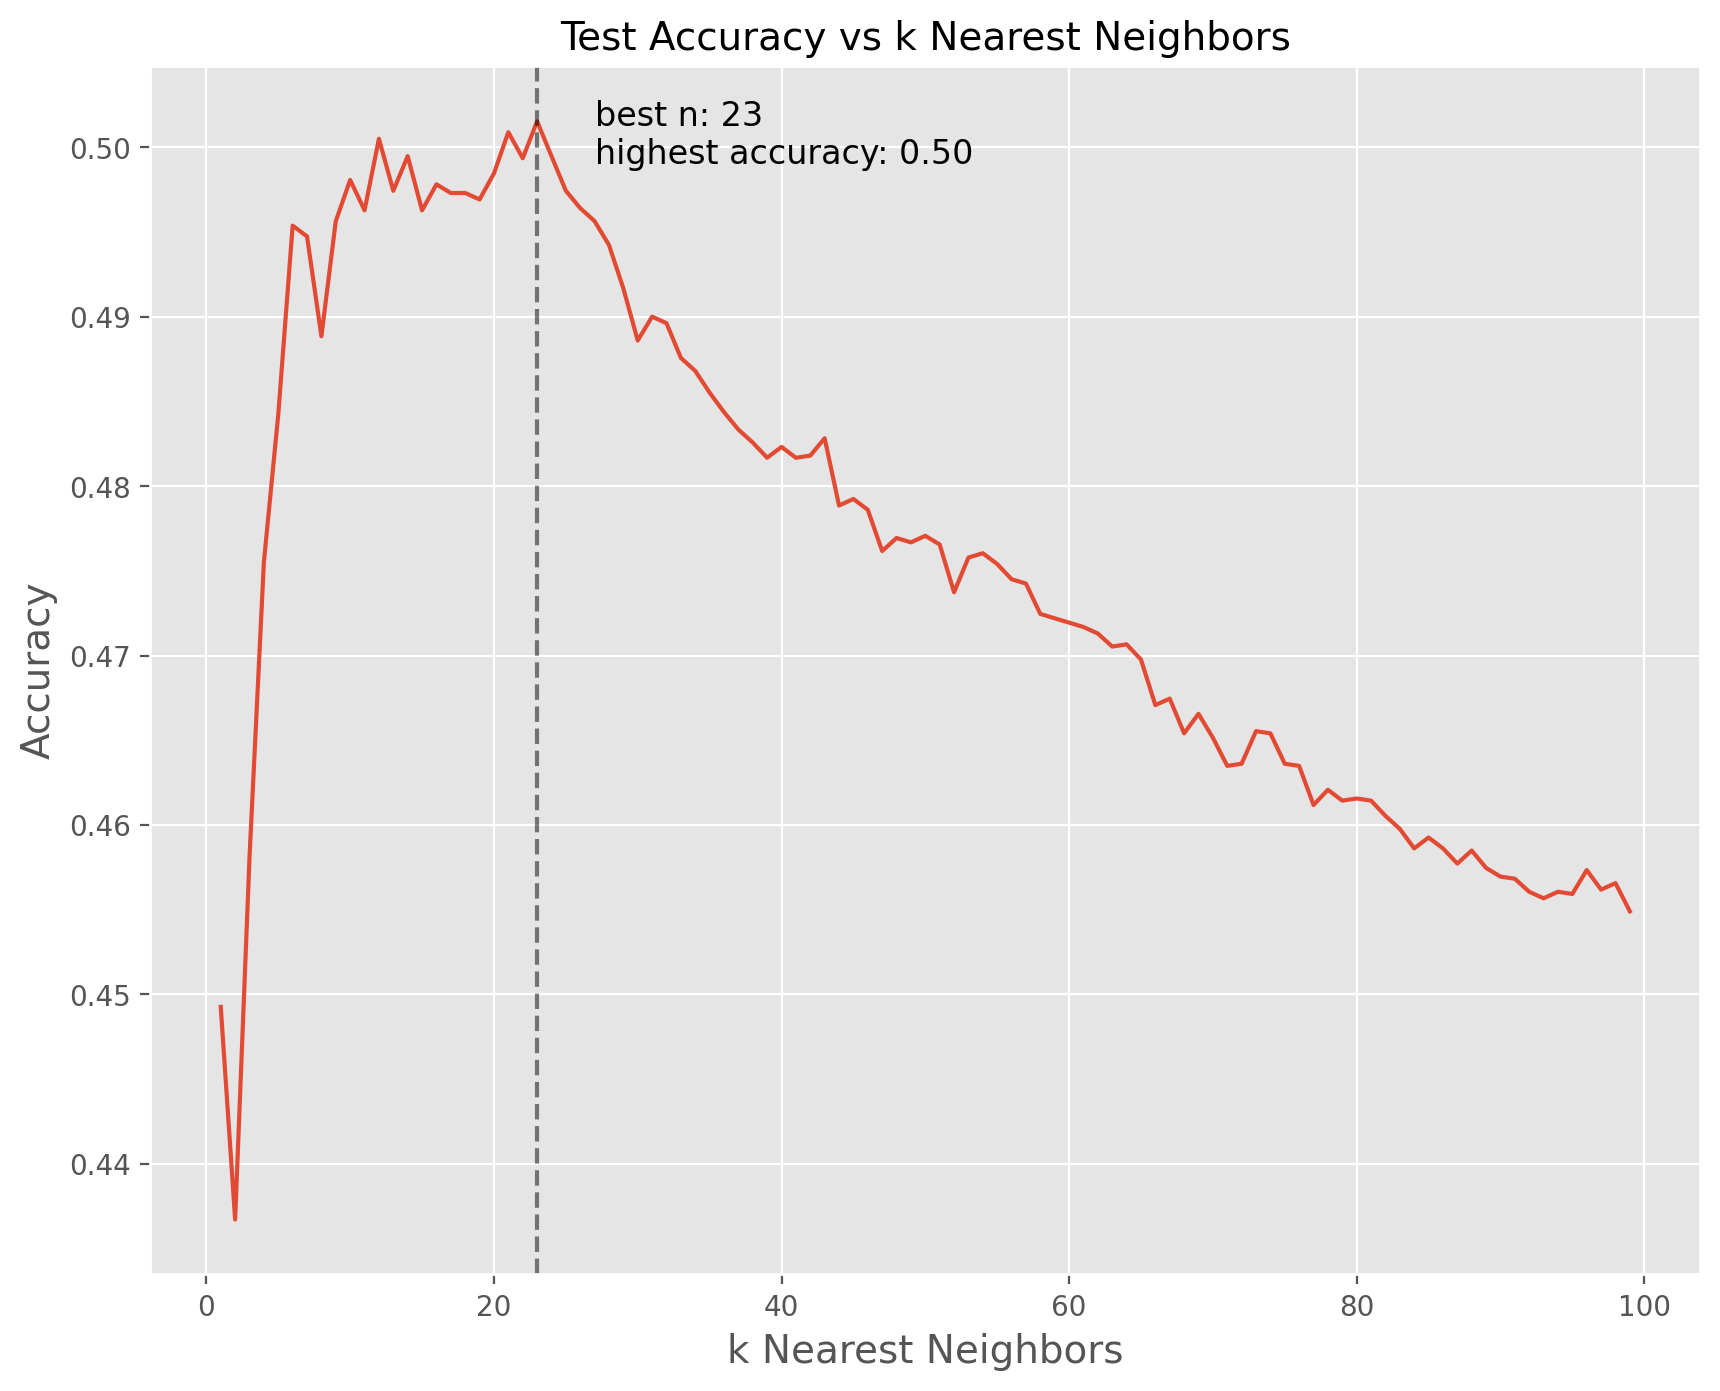

In [46]:
# Plot cross-validation scores for different numbers of
# nearest neighbors with 10 kfolds
cv_scores = []
max_score = 0
max_n = 0
for n in range(1,100):
    cv_score = cross_val(X_train, y_train, k=10, n=n)
    cv_scores.append(cv_score)
    if cv_score > max_score:
        max_score = cv_score
        max_n = n


fig, ax = plt.subplots(figsize=(10,8), dpi=200)    
ax.plot(list(range(1,100)),cv_scores)
ax.axvline(max_n, linestyle='--',c='k',alpha=0.5)
ax.text(max_n+4, max_score-0.0025,
        s=f'best n: {max_n}\nhighest accuracy: {max_score:.2f}',
        fontsize=12)
ax.set_xlabel('k Nearest Neighbors', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.tick_params(axis='both',which='major',labelsize=10)
ax.set_title('Test Accuracy vs k Nearest Neighbors', fontsize=14);

plt.savefig('../imgs/accuracy_vs_nearestneighbors.png')

## Logistic Regression

In [ ]:
log_clf = LogisticRegression(multi_class='multinomial',max_iter=100)